# Preliminaries + Installs

These instructions are for Python 3.10
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy pypdf langchain-unstructured "unstructured[pdf]" --user`
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
import os
from os import path, makedirs
# from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PDF_ERROR"]  = "data/input/BAD_PDF"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =   "400" #"25" #"200"
environ["_RAG_DOC_LIMIT"]  = "10000"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"

if not path.exists( environ["_RAG_PDF_ERROR"] ):
    makedirs( environ["_RAG_PDF_ERROR"] )


## Determine if more docs will be loaded this session

In [4]:
%%capture
# Loading the vector store sometimes spews warnings

__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient();
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] );

pdfs_drct   = environ["_RAG_PDF_DESTIN"]
eror_drct   = environ["_RAG_PDF_ERROR" ]
fNames      = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]

environ["_RAG_PDF_COUNT"   ] = str( len( fNames ) )
environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate['libDocs']), int(environ["_RAG_DOC_ADD"]) ) )


In [5]:
from utils import copy_pdfs

print( f"{environ['_RAG_PDF_COUNT' ]} input PDFs exist!" )
print( f"{environ['_RAG_DOCDB_COUNT' ]} vector records exist!" )
print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs( environ["_RAG_PDF_SOURCE"], environ["_RAG_PDF_DESTIN"], 
           int(environ['_RAG_DOCDB_REMAIN']), verbose = environ["_RAG_VERBOSE"] )

5735 input PDFs exist!
115904 vector records exist!
400 files will be copied!
.........................................................................................................................


## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [6]:

def collect_unique_metadata_by_key( key ):
    """ Return a list of unqiue metadata values from the vector store by `key` """
    global collection
    unique = set()
    for result in collection.get()['metadatas']:
       if key in result:
           unique.add( result[key] )
    return list( unique )


def find_unread_PDFs_at_input():
    """ Return a list of PDF paths that do NOT have pages in the vector store """
    global RAGstate
    inputPDFs = collect_unique_metadata_by_key( 'source' )
    rtnPaths  = list()
    for pdf in inputPDFs:
        if pdf not in RAGstate['libDocs']:
            rtnPaths.append( pdf )
    return rtnPaths
            

In [7]:
import os, shutil
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

pages = deque() # Fast append


# needToParse = find_unread_PDFs_at_input()
# fNames.extend( needToParse )

print( f"There are {len(fNames)} candidate files!" )

if len( fNames ) > 0:
    bgn    = now()
    lastLn = 0
    Nexist = 0
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) ) # fNam # str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            try:
                loader    = PyPDFLoader( file_path )
                async for page in loader.alazy_load():
                    pages.append( page )
                print( f"{i+1}:{len(pages)-lastLn}:{len(pages)}", end = ', ', flush = True )
                lastLn = len(pages)
            except Exception as e:
                print( f"ERROR:{e}", end = ', ', flush = True )
                try:
                    shutil.move( file_path, path.join( eror_drct, fNam ) )
                except Exception as e:
                    print( f"FAILED to move {file_path} --to-> {path.join( eror_drct, fNam )}" )
            except asyncio.CancelledError as e:
                print( f"Load operation cancelled by user" )
                raise e
        else:
            Nexist += 1
                    
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0:.2f} minutes! (Skipped {Nexist} existing PDFs.)" )

save_state()

There are 5735 candidate files!
7:13:13, 

Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 40 0 (offset 0)
Ignoring wrong pointing object 73 0 (offset 0)
Ignoring wrong pointing object 80 0 (offset 0)
Ignoring wrong pointing object 82 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)
Ignoring wrong pointing object 101 0 (offset 0)
Ignoring wrong pointing object 140 0 (offset 0)
Ignoring wrong pointing object 156 0 (offset 0)
Ignoring wrong pointing object 167 0 (offset 0)
Ignoring wrong pointing object 178 0 (offset 0)
Ignoring wrong pointing object 189 0 (offset 0)
Ignoring wrong pointing object 230 0 (offset 0)
Ignoring wrong pointing object 246 0 (offset 0)
Ignoring wrong pointing object 257 0 (offset 0)
Ignoring wrong pointing object 268 0 (offset 0)
Ignoring wrong pointing object 279 0 (offset 0)
Ignoring wrong pointing object 312 0 (offset 0)
I

23:19:32, 31:6:38, 35:7:45, 59:62:107, 68:6:113, 69:37:150, 81:41:191, 88:7:198, 119:10:208, 121:8:216, 149:14:230, 151:16:246, 152:23:269, 153:8:277, 154:16:293, 169:8:301, 181:8:309, 183:8:317, 187:15:332, 189:23:355, 190:12:367, 191:16:383, 220:47:430, 223:10:440, 224:20:460, 226:10:470, 250:7:477, 253:14:491, 255:18:509, 267:13:522, 274:9:531, 275:16:547, 277:7:554, 283:36:590, 294:13:603, 300:27:630, 

could not convert string to float: '0.00-10' : FloatObject (b'0.00-10') invalid; use 0.0 instead
could not convert string to float: '0.00-60' : FloatObject (b'0.00-60') invalid; use 0.0 instead
could not convert string to float: '0.00-60' : FloatObject (b'0.00-60') invalid; use 0.0 instead
could not convert string to float: '0.00-60' : FloatObject (b'0.00-60') invalid; use 0.0 instead
could not convert string to float: '0.00-60' : FloatObject (b'0.00-60') invalid; use 0.0 instead


305:8:638, 320:15:653, 321:13:666, 348:8:674, 354:18:692, 356:17:709, 360:11:720, 377:8:728, 390:10:738, 396:10:748, 398:17:765, 400:27:792, 410:640:1432, 413:39:1471, 414:14:1485, 415:5:1490, 445:26:1516, 449:12:1528, 458:3:1531, 463:24:1555, 474:32:1587, 476:29:1616, 479:23:1639, 484:64:1703, 485:30:1733, 505:3:1736, 508:6:1742, 516:21:1763, 526:18:1781, 534:267:2048, 540:10:2058, 

Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)
Ignoring wrong pointing object 19 0 (offset 0)
Ignoring wrong pointing object 60 0 (offset 0)
Ignoring wrong pointing object 81 0 (offset 0)


543:23:2081, 

Ignoring wrong pointing object 11 0 (offset 0)


563:7:2088, 575:21:2109, 580:8:2117, 591:8:2125, 598:27:2152, 600:31:2183, 601:10:2193, 608:16:2209, 609:38:2247, 623:26:2273, 645:10:2283, 651:14:2297, 654:32:2329, 663:14:2343, 666:3:2346, 676:10:2356, 677:12:2368, 

Ignoring wrong pointing object 87 0 (offset 0)


678:10:2378, 681:70:2448, 695:13:2461, 701:16:2477, 710:12:2489, 711:9:2498, 723:8:2506, 733:13:2519, 740:7:2526, 751:10:2536, 753:3:2539, 754:8:2547, 756:24:2571, 758:7:2578, 766:17:2595, 768:8:2603, 773:7:2610, 779:9:2619, 780:7:2626, 788:8:2634, 794:2:2636, 799:19:2655, 811:38:2693, 820:14:2707, 829:16:2723, 833:3:2726, 838:9:2735, 857:38:2773, 861:6:2779, 864:9:2788, 868:11:2799, 875:11:2810, 882:7:2817, 888:17:2834, 889:11:2845, 896:60:2905, 912:16:2921, 916:9:2930, 922:12:2942, 931:18:2960, 945:27:2987, 948:29:3016, 981:21:3037, 991:7:3044, 996:12:3056, 1000:6:3062, 1009:13:3075, 1027:25:3100, 1028:6:3106, 1029:10:3116, 1032:32:3148, 1035:48:3196, 1038:25:3221, 1053:14:3235, 1055:88:3323, 1057:8:3331, 1061:10:3341, 1066:8:3349, 1075:19:3368, 1082:27:3395, 1083:144:3539, 1095:18:3557, 1096:14:3571, 1110:8:3579, 1114:6:3585, 1126:9:3594, 1129:7:3601, 1143:20:3621, 1145:14:3635, 1153:8:3643, 

Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet


1157:28:3671, 1162:12:3683, 1165:9:3692, 1173:13:3705, 1187:30:3735, 1188:8:3743, 1194:20:3763, 1195:7:3770, 1223:11:3781, 1228:14:3795, 1231:8:3803, 1237:33:3836, 1242:14:3850, 1250:8:3858, 1259:10:3868, 1268:9:3877, 1274:24:3901, 1285:17:3918, 1288:17:3935, 1294:10:3945, 1295:5:3950, 1297:12:3962, 1316:10:3972, 1329:9:3981, 1332:8:3989, 1345:10:3999, 1348:18:4017, 1364:25:4042, 1372:10:4052, 1375:33:4085, 1376:5:4090, 1394:30:4120, 1415:13:4133, 1426:17:4150, 1444:16:4166, 1458:78:4244, 1461:4:4248, 1480:6:4254, 1491:10:4264, 1499:44:4308, 1501:7:4315, 1508:8:4323, 1527:10:4333, 1533:21:4354, 1542:15:4369, 1546:10:4379, 1549:16:4395, 1552:9:4404, 1554:8:4412, 

Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 24 0 (offset 0)
Ignoring wrong pointing object 59 0 (offset 0)
Ignoring wrong pointing object 174 0 (offset 0)


1557:38:4450, 1562:10:4460, 1581:5:4465, 1585:126:4591, 1588:5:4596, 1591:67:4663, 1597:12:4675, 1599:24:4699, 1604:12:4711, 1607:6:4717, 1613:8:4725, 1617:197:4922, 1624:43:4965, 1625:7:4972, 1654:12:4984, 1656:17:5001, 1657:11:5012, 1660:20:5032, 1661:18:5050, 1665:9:5059, 1667:14:5073, 1668:25:5098, 1675:12:5110, 1678:13:5123, 1681:21:5144, 1685:3:5147, 1689:10:5157, 1697:19:5176, 1699:4:5180, 1711:256:5436, 1713:10:5446, 1714:10:5456, 1719:3:5459, 1722:6:5465, 1725:14:5479, 1731:88:5567, 1746:28:5595, 1748:7:5602, 1752:6:5608, 1758:6:5614, 1768:19:5633, 1774:19:5652, 1780:14:5666, 1782:8:5674, 1787:30:5704, 1794:5:5709, 1796:7:5716, 1806:7:5723, 1815:38:5761, 

Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 45 0 (offset 0)


1816:2:5763, 1819:16:5779, 1845:27:5806, 1851:7:5813, 1854:7:5820, 1861:28:5848, 1869:13:5861, 1880:37:5898, 

Ignoring wrong pointing object 2 65536 (offset 0)
Ignoring wrong pointing object 21 65536 (offset 0)
Ignoring wrong pointing object 51 65536 (offset 0)
Ignoring wrong pointing object 55 65536 (offset 0)
Ignoring wrong pointing object 74 65536 (offset 0)
Ignoring wrong pointing object 78 65536 (offset 0)
Ignoring wrong pointing object 87 65536 (offset 0)
Ignoring wrong pointing object 96 65536 (offset 0)
Ignoring wrong pointing object 108 65536 (offset 0)
Ignoring wrong pointing object 112 65536 (offset 0)
Ignoring wrong pointing object 116 65536 (offset 0)
Ignoring wrong pointing object 120 65536 (offset 0)
Ignoring wrong pointing object 139 65536 (offset 0)
Ignoring wrong pointing object 156 65536 (offset 0)
Ignoring wrong pointing object 170 65536 (offset 0)
Ignoring wrong pointing object 182 65536 (offset 0)
Ignoring wrong pointing object 196 65536 (offset 0)
Ignoring wrong pointing object 200 65536 (offset 0)
Ignoring wrong pointing object 211 65536 (offset 0)
Ignoring wrong pointi

1882:39:5937, 1885:12:5949, 1889:20:5969, 1896:9:5978, 1904:25:6003, 1923:16:6019, 1937:6:6025, 1938:18:6043, 1943:8:6051, 1950:91:6142, 1953:4:6146, 1956:24:6170, 1975:8:6178, 1977:12:6190, 1989:7:6197, 2009:9:6206, 2012:14:6220, 2023:11:6231, 2028:15:6246, 2034:15:6261, 2040:19:6280, 2042:19:6299, 2057:6:6305, 2064:10:6315, 2065:20:6335, 2069:2:6337, 2081:12:6349, 2092:7:6356, 2101:9:6365, 

Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 62 0 (offset 0)
Ignoring wrong pointing object 81 0 (offset 0)
Ignoring wrong pointing object 83 0 (offset 0)
Ignoring wrong pointing object 85 0 (offset 0)
Ignoring wrong pointing object 89 0 (offset 0)
Ignoring wrong pointing object 94 0 (offset 0)
Ignoring wrong pointing object 199 0 (offset 0)
Ignoring wrong pointing object 203 0 (offset 0)
Ignoring wrong pointing object 227 0 (offset 0)
Ignoring wrong pointing object 232 0 (offset 0)
Ignoring wrong pointing object 242 0 (offset 0)
Ignoring wrong pointing object 250 0 (offset 0)
Ignoring wrong pointing object 258 0 (offset 0)
Ignoring wrong pointing object 283 0 (offset 0)
Ignoring wrong pointing object 299 0 (offset 0)
Ignoring wrong pointing object 322 0 (offset 0)
Ignoring wrong pointing object 327 0 (offset 0)
Ignoring wrong pointing object 375 0 (offset 0)
I

2104:49:6414, 2106:14:6428, 2110:125:6553, 2119:10:6563, 2120:22:6585, 2123:7:6592, 2125:927:7519, 2143:13:7532, 2153:12:7544, 2154:3:7547, 2165:22:7569, 2183:17:7586, 2200:15:7601, 2205:10:7611, 

Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "
Unexpected escaped string: "


2217:6:7617, 2223:48:7665, 2225:11:7676, 2231:16:7692, 2242:16:7708, 2243:17:7725, 2253:8:7733, 2256:21:7754, 2257:25:7779, 2262:2:7781, 2263:17:7798, 2265:22:7820, 2273:35:7855, 2275:8:7863, 2294:10:7873, 2297:11:7884, 2301:22:7906, 2314:11:7917, 2315:17:7934, 2317:8:7942, 2321:3:7945, 2330:30:7975, 2331:26:8001, 2334:7:8008, 2352:8:8016, 2355:6:8022, 2368:23:8045, 2369:6:8051, 2374:4:8055, 2375:8:8063, 2383:27:8090, 2385:5:8095, 2388:11:8106, 

Ignoring wrong pointing object 91 0 (offset 0)
Ignoring wrong pointing object 231 0 (offset 0)


2408:22:8128, 2410:42:8170, 2414:27:8197, 2417:33:8230, 2420:8:8238, 2424:12:8250, 2426:12:8262, 2429:7:8269, 2432:9:8278, 2437:7:8285, 2449:492:8777, 2450:16:8793, 2482:8:8801, 2493:17:8818, 2497:20:8838, 2506:45:8883, 2508:7:8890, 2510:9:8899, 2522:21:8920, 2538:38:8958, 2544:218:9176, 2547:13:9189, 2549:12:9201, 2575:7:9208, 2581:39:9247, 2583:69:9316, 2587:6:9322, 2589:8:9330, 2594:389:9719, 2608:19:9738, 2612:17:9755, 2615:13:9768, 2641:12:9780, 2643:10:9790, 2654:6:9796, 2656:8:9804, 2666:7:9811, 

Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet


2670:14:9825, 2673:8:9833, 

Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 129 0 (offset 0)


2682:12:9845, 2699:20:9865, 2721:23:9888, 2724:6:9894, 2725:7:9901, 2726:10:9911, 2737:20:9931, 2757:12:9943, 2765:33:9976, 2778:12:9988, 2784:17:10005, 2800:7:10012, 2812:12:10024, 2815:10:10034, 2829:6:10040, 2838:18:10058, 2841:20:10078, 2846:2:10080, 2847:11:10091, 2862:48:10139, 2864:10:10149, 2866:14:10163, 2873:33:10196, 2885:8:10204, 2892:15:10219, 2897:6:10225, 2907:8:10233, 2921:19:10252, 2933:5:10257, 2937:11:10268, 2938:6:10274, 2942:17:10291, 2946:219:10510, 

Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 138 0 (offset 0)
Ignoring wrong pointing object 141 0 (offset 0)
Ignoring wrong pointing object 146 0 (offset 0)


2948:16:10526, 2964:11:10537, 2976:16:10553, 2986:13:10566, 2990:8:10574, 3001:18:10592, 3010:10:10602, 3019:15:10617, 3026:10:10627, 

Ignoring wrong pointing object 269 0 (offset 0)
Ignoring wrong pointing object 327 0 (offset 0)
Ignoring wrong pointing object 332 0 (offset 0)
Ignoring wrong pointing object 393 0 (offset 0)
Ignoring wrong pointing object 396 0 (offset 0)
Ignoring wrong pointing object 400 0 (offset 0)
Ignoring wrong pointing object 403 0 (offset 0)
Ignoring wrong pointing object 405 0 (offset 0)
Ignoring wrong pointing object 407 0 (offset 0)
Ignoring wrong pointing object 409 0 (offset 0)
Ignoring wrong pointing object 414 0 (offset 0)
Ignoring wrong pointing object 418 0 (offset 0)
Ignoring wrong pointing object 421 0 (offset 0)
Ignoring wrong pointing object 424 0 (offset 0)
Ignoring wrong pointing object 428 0 (offset 0)
Ignoring wrong pointing object 432 0 (offset 0)
Ignoring wrong pointing object 435 0 (offset 0)
Ignoring wrong pointing object 511 0 (offset 0)
Ignoring wrong pointing object 637 0 (offset 0)
Ignoring wrong pointing object 699 0 (offset 0)
Ignoring wrong pointing object 1350 0 (o

3043:103:10730, 3053:1:10731, 3072:12:10743, 3075:17:10760, 3080:5:10765, 3093:8:10773, 3096:21:10794, 3099:10:10804, 3108:6:10810, 3109:10:10820, 3111:14:10834, 3117:18:10852, 3120:8:10860, 3131:22:10882, 3132:173:11055, 3137:20:11075, 3138:8:11083, 3139:19:11102, 3140:14:11116, 3146:3:11119, 3158:6:11125, 3163:6:11131, 3165:14:11145, 3168:3:11148, 3169:1:11149, 3170:32:11181, 3180:12:11193, 3185:12:11205, 3186:17:11222, 3187:9:11231, 3201:20:11251, 3202:58:11309, 3210:15:11324, 3215:13:11337, 3230:9:11346, 3231:11:11357, 3239:6:11363, 3254:23:11386, 3255:64:11450, 3269:15:11465, 3270:8:11473, 3276:17:11490, 3278:21:11511, 3302:9:11520, 3309:17:11537, 3311:41:11578, 3334:182:11760, 3342:31:11791, 3346:14:11805, 3348:7:11812, 3350:13:11825, 3355:10:11835, 3367:50:11885, 3371:94:11979, 3377:10:11989, 3384:4:11993, 3393:8:12001, 3413:2:12003, 3417:10:12013, 3420:16:12029, 3421:12:12041, 3435:14:12055, 3448:11:12066, 3459:44:12110, 3471:38:12148, 3475:9:12157, 3476:14:12171, 3477:86:12257

Ignoring wrong pointing object 0 0 (offset 0)


3703:26:12772, 3708:13:12785, 3714:16:12801, 3717:8:12809, 3721:21:12830, 3732:40:12870, 3745:24:12894, 3771:21:12915, 3789:9:12924, 3792:24:12948, 3802:16:12964, 3807:23:12987, 3809:8:12995, 3812:8:13003, 3820:46:13049, 3824:29:13078, 3830:17:13095, 3831:21:13116, 3833:15:13131, 3845:8:13139, 3853:10:13149, 3859:3:13152, 3865:15:13167, 3871:80:13247, 3877:8:13255, 

Ignoring wrong pointing object 61 0 (offset 0)
Ignoring wrong pointing object 73 0 (offset 0)
Ignoring wrong pointing object 83 0 (offset 0)
Ignoring wrong pointing object 85 0 (offset 0)
Ignoring wrong pointing object 88 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)
Ignoring wrong pointing object 181 0 (offset 0)
Ignoring wrong pointing object 183 0 (offset 0)
Ignoring wrong pointing object 227 0 (offset 0)
Ignoring wrong pointing object 229 0 (offset 0)
Ignoring wrong pointing object 297 0 (offset 0)
Ignoring wrong pointing object 299 0 (offset 0)


3878:6:13261, 3887:12:13273, 3889:4:13277, 3890:10:13287, 3893:12:13299, 3898:30:13329, 3900:8:13337, 3903:11:13348, 3905:14:13362, 3925:30:13392, 3930:14:13406, 3944:7:13413, 3946:17:13430, 3950:7:13437, 3954:13:13450, 3956:7:13457, 3964:33:13490, 3971:18:13508, 3972:8:13516, 3979:13:13529, 3984:89:13618, 3987:19:13637, 3991:19:13656, 3995:4:13660, 3999:24:13684, 4001:12:13696, 4003:25:13721, 4007:2:13723, 4013:18:13741, 4025:506:14247, 4029:20:14267, 4045:75:14342, 4054:8:14350, 4059:17:14367, 4088:11:14378, 4089:18:14396, 4091:16:14412, 4114:7:14419, 4117:13:14432, 4120:17:14449, 4129:19:14468, 4138:12:14480, 4141:19:14499, 4148:7:14506, 4149:2:14508, 4150:17:14525, 4156:13:14538, 4159:38:14576, 4163:10:14586, 4171:14:14600, 4172:19:14619, 4175:12:14631, 4176:6:14637, 4178:11:14648, 4182:15:14663, 4193:11:14674, 4197:20:14694, 4200:12:14706, 4216:11:14717, 4217:7:14724, 4228:13:14737, 4230:6:14743, 4236:14:14757, 

Ignoring wrong pointing object 110 0 (offset 0)
Ignoring wrong pointing object 112 0 (offset 0)


4241:28:14785, 4250:19:14804, 4259:8:14812, 4268:2:14814, 

could not convert string to float: '0.00-27808675' : FloatObject (b'0.00-27808675') invalid; use 0.0 instead
could not convert string to float: '0.00-23380874' : FloatObject (b'0.00-23380874') invalid; use 0.0 instead
could not convert string to float: '0.00-23380874' : FloatObject (b'0.00-23380874') invalid; use 0.0 instead
could not convert string to float: '0.00-23380874' : FloatObject (b'0.00-23380874') invalid; use 0.0 instead
could not convert string to float: '0.00-23380874' : FloatObject (b'0.00-23380874') invalid; use 0.0 instead
could not convert string to float: '0.00-29832934' : FloatObject (b'0.00-29832934') invalid; use 0.0 instead
could not convert string to float: '0.00-29832934' : FloatObject (b'0.00-29832934') invalid; use 0.0 instead
could not convert string to float: '0.00-29832934' : FloatObject (b'0.00-29832934') invalid; use 0.0 instead


4279:20:14834, 4287:17:14851, 4288:39:14890, 4308:11:14901, 

could not convert string to float: '0.00-20' : FloatObject (b'0.00-20') invalid; use 0.0 instead
could not convert string to float: '0.00-20' : FloatObject (b'0.00-20') invalid; use 0.0 instead
could not convert string to float: '0.00-20' : FloatObject (b'0.00-20') invalid; use 0.0 instead
could not convert string to float: '0.00-20' : FloatObject (b'0.00-20') invalid; use 0.0 instead


4310:10:14911, 4318:10:14921, 4320:30:14951, 4335:12:14963, 4337:131:15094, 4338:6:15100, 4349:12:15112, 4352:19:15131, 4362:13:15144, 4368:14:15158, 4370:220:15378, 4372:5:15383, 4403:19:15402, 4406:25:15427, 4416:16:15443, 4421:7:15450, 4426:8:15458, 4430:25:15483, 4431:13:15496, 4436:7:15503, 4438:9:15512, 4457:21:15533, 4458:10:15543, 4460:10:15553, 4475:192:15745, 4479:17:15762, 4480:13:15775, 4486:20:15795, 4494:13:15808, 4495:29:15837, 4513:16:15853, 4518:10:15863, 4519:9:15872, 4524:20:15892, 4525:9:15901, 4533:32:15933, 4555:10:15943, 4559:15:15958, 4560:17:15975, 4566:18:15993, 4580:19:16012, 4583:15:16027, 4584:10:16037, 4585:6:16043, 4587:43:16086, 4593:27:16113, 4597:8:16121, 4621:17:16138, 4634:15:16153, 4652:20:16173, 4655:13:16186, 4677:24:16210, 4680:11:16221, 4691:99:16320, 4703:8:16328, 4704:13:16341, 4714:14:16355, 4722:9:16364, 

Ignoring wrong pointing object 40 0 (offset 0)
Ignoring wrong pointing object 44 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 52 0 (offset 0)
Ignoring wrong pointing object 55 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 89 0 (offset 0)
Ignoring wrong pointing object 95 0 (offset 0)
Ignoring wrong pointing object 101 0 (offset 0)
Ignoring wrong pointing object 104 0 (offset 0)
Ignoring wrong pointing object 108 0 (offset 0)
Ignoring wrong pointing object 110 0 (offset 0)
Ignoring wrong pointing object 115 0 (offset 0)
Ignoring wrong pointing object 121 0 (offset 0)
Ignoring wrong pointing object 127 0 (offset 0)
Ignoring wrong pointing object 130 0 (offset 0)
Ignoring wrong pointing object 134 0 (offset 0)
Ignoring wrong pointing object 136 0 (offset 0)
Ignoring wrong pointing object 142 0 (offset 0)
Ignoring wrong pointing object 148 0 (offset 0)
Ignoring wrong pointing object 151 0 (offset 0)


4731:8:16372, 4750:12:16384, 4778:47:16431, 4788:7:16438, 4792:14:16452, 4796:8:16460, 4809:92:16552, 4813:94:16646, 4816:13:16659, 4822:19:16678, 4823:5:16683, 4827:20:16703, 4828:21:16724, 4832:37:16761, 4847:16:16777, 4855:23:16800, 4856:23:16823, 4864:7:16830, 4884:22:16852, 4887:12:16864, 4893:12:16876, 4898:37:16913, 

Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 37 0 (offset 0)


4907:21:16934, 4909:10:16944, 4913:9:16953, 4916:18:16971, 4921:264:17235, 4925:14:17249, 4937:19:17268, 4939:91:17359, 4944:37:17396, 4945:13:17409, 4949:8:17417, 4955:32:17449, 4961:42:17491, 4964:23:17514, 4972:198:17712, 4975:8:17720, 4989:12:17732, 4997:8:17740, 5001:11:17751, 5010:10:17761, 5013:3:17764, 5016:19:17783, 5025:15:17798, 5058:2:17800, 5059:59:17859, 5070:13:17872, 5074:13:17885, 5078:66:17951, 5082:22:17973, 5090:7:17980, 5094:10:17990, 5098:10:18000, 5101:8:18008, 5110:44:18052, 5132:44:18096, 5155:16:18112, 5157:21:18133, 5159:9:18142, 5164:17:18159, 5182:11:18170, 5183:39:18209, 5190:12:18221, 5201:12:18233, 5206:305:18538, 5230:19:18557, 5234:7:18564, 

could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead
could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead
could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead
could not convert string to float: '0.00-30' : FloatObject (b'0.00-30') invalid; use 0.0 instead


5248:21:18585, 5251:20:18605, 5259:13:18618, 5261:6:18624, 5268:11:18635, 5314:11:18646, 

Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet
Advanced encoding [] not implemented yet


5318:15:18661, 5319:7:18668, 5329:34:18702, 5330:20:18722, 5338:8:18730, 5347:4:18734, 5352:8:18742, 5355:12:18754, 5358:7:18761, 5359:13:18774, 5361:10:18784, 5369:26:18810, 5382:19:18829, 5384:10:18839, 

Ignoring wrong pointing object 55 0 (offset 0)


5396:11:18850, 5402:26:18876, 5403:17:18893, 5405:10:18903, 5408:6:18909, 5413:8:18917, 5429:4:18921, 5483:39:18960, 5491:19:18979, 5493:7:18986, 5498:11:18997, 5499:11:19008, 5500:28:19036, 5501:7:19043, 5521:157:19200, 5527:8:19208, 5544:31:19239, 5546:9:19248, 5547:10:19258, 5548:11:19269, 5553:17:19286, 5556:7:19293, 5592:9:19302, 5596:8:19310, 5602:8:19318, 5629:8:19326, 5631:27:19353, 5632:36:19389, 5633:565:19954, 5642:7:19961, 5651:20:19981, 5676:6:19987, 5681:6:19993, 5685:17:20010, 5687:23:20033, 5696:127:20160, 5697:6:20166, 5711:15:20181, 5717:6:20187, 5719:7:20194, 5720:25:20219, 5725:9:20228, 5732:8:20236, 
Read 20236 pages in 16.49 minutes! (Skipped 4936 existing PDFs.)


In [8]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [9]:
import sys, os, time
now = time.time

from langchain_ollama import OllamaEmbeddings

pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [10]:
import base64
import io

import fitz, pymupdf
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    zoom_x       = 1.5  # horizontal zoom
    zoom_y       = 1.5  # vertical zoom
    mat          = pymupdf.Matrix( zoom_x, zoom_y )
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap( matrix = mat )
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [11]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs  = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts  = [str( pg.page_content ) for pg in pages]
    metaDt  = list() # FIXME: MAKE THIS A DEQUE
    d       = 50
    readSet = set([])

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        src = pg.metadata['source']

        #  vv- Quick Search -vv     vvvvv--- Long Search ---vvvvvvvv
        if (src not in readSet) and (src not in RAGstate['libDocs']):
            readSet.add( src )
            RAGstate['libDocs'].append( src )

        # Save PDF Page image #
        try:
            pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
            pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
            
            with open( pkl_i, 'wb' ) as f:
                RAGstate['pages'][ id_i ] = str( pkl_i )
                pickle.dump( pgPic, f )
        except Exception as e:
            print( f"Could NOT save image ID {id_i}!, {e}" )

        if (i % d == 0):
            print( '.', end='', flush = True )
    print()
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0:.2f} minutes!" )

save_state()



.....................................................................................................................................................................................................................................................................................................................MuPDF error: syntax error: unknown keyword: 'pagesize'

MuPDF error: syntax error: unknown keyword: 'width'

MuPDF error: syntax error: unknown keyword: '614.295pt'

MuPDF error: syntax error: unknown keyword: 'height'

MuPDF error: syntax error: unknown keyword: '794.96999pt'

.......................MuPDF error: syntax error: could not parse color space (272 0 R)

.MuPDF error: syntax error: could not parse color space (272 0 R)

................................MuPDF error: library error: FT_New_Memory_Face(CMTI10): invalid argument

MuPDF error: library error: FT_New_Memory_Face(CMTI10): invalid argument

MuPDF error: library error: FT_New_Memory_Face(CMTI10): invalid argument

Mu

Exception occurred invoking consumer for subscription 4ba4e31e462942528ca2686ac685575eto topic persistent://default/default/a84553ac-5e8e-4481-8051-a5e59bf2af75 'utf-8' codec can't encode characters in position 117-118: surrogates not allowed


Added 20236 documents in 39.60 minutes!


# Create vector store

In [12]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn):.4f} seconds!" )

Built vector store in 0.0062 seconds!


# Load VLM

In [13]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [14]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [15]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [16]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [17]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    bgn = now()
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    print( f"Initial LLM summary took {now()-bgn:.2f} seconds to process!" )
    
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn:.2f} seconds to process!" )
        pprint( response.content )

(' In order for nuclear fusion to occur in a confined plasma, several '
 'conditions must be met. These include:\n'
 '\n'
 '1. High Temperature: Nuclear fusion requires that the plasma be heated to '
 'temperatures much higher than those found on Earth. Typically, these '
 'temperatures are in the range of 100 million degrees Celsius or more. This '
 'is necessary because the nuclear reactions that occur during fusion require '
 'a high energy input and the plasma must be hot enough for the atomic nuclei '
 'to overcome their electrostatic repulsion and come into close enough contact '
 'to allow the fusion reaction to take place.\n'
 '2. High Pressure: In addition to being heated, the plasma must also be '
 'compressed or subjected to high pressure in order to achieve the necessary '
 'density for nuclear fusion. This is because the probability of a successful '
 'fusion reaction increases with the number of particles (i.e., nuclei) in '
 'close proximity to each other.\n'
 '3. Magnet

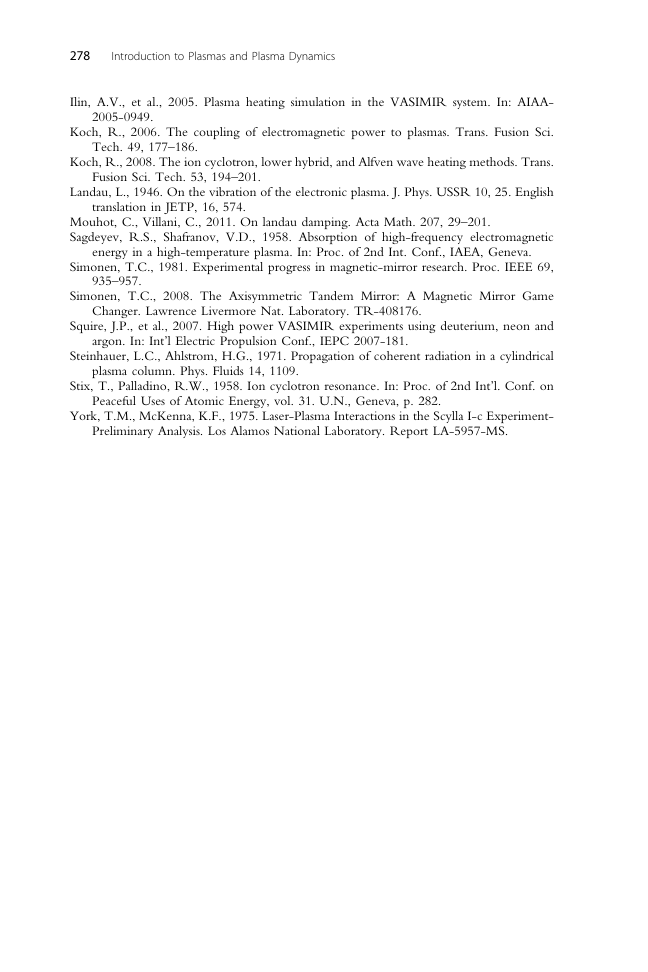

LLM query took 11.78 seconds to process!
(' The image shows a page with text, which appears to be an academic or '
 'scientific paper. The text is too small for me to read the specific details '
 'in full. However, I can see that it contains a section titled "Nuclear '
 'Fusion in a Confined Plasma." This section seems to discuss the conditions '
 'necessary for nuclear fusion to occur within a confined plasma environment. '
 'These conditions typically include high temperatures and pressures, as well '
 'as the presence of charged particles (ions) at high densities. The text is '
 'discussing how these conditions are achieved and maintained in practical '
 'nuclear fusion experiments or devices, such as tokamaks. ')


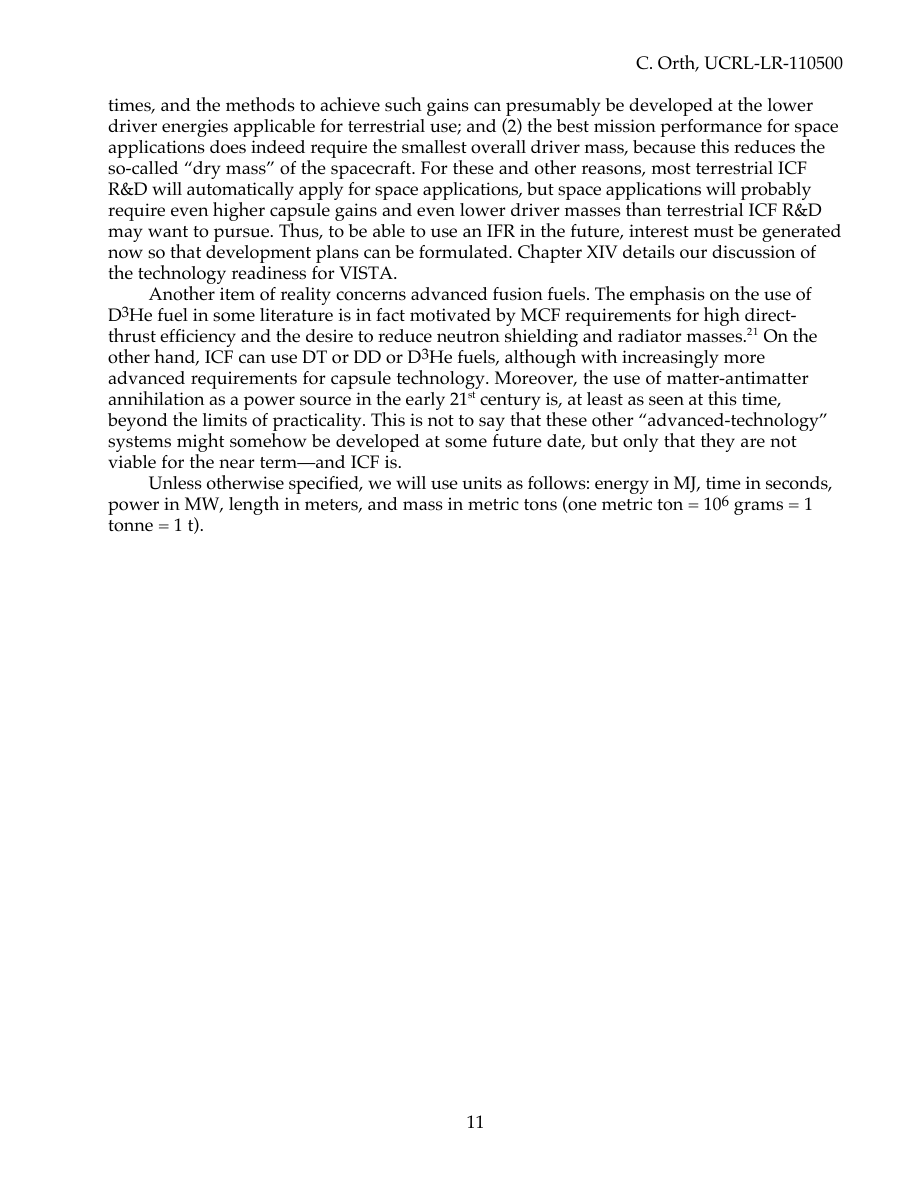

LLM query took 25.67 seconds to process!
(' The text in the image is a bit blurry and small, but it seems to be '
 'discussing nuclear fusion, specifically in a confined plasma. The conditions '
 'necessary for nuclear fusion in such a setup typically include:\n'
 '\n'
 '1. High Temperature: Nuclear fusion requires extreme temperatures, often '
 'millions of degrees Celsius or more, to overcome the electrostatic repulsion '
 'between atomic nuclei and initiate fusion reactions.\n'
 '\n'
 '2. Dense Plasma: A dense plasma is necessary because it increases the '
 'likelihood of nuclear collisions that can produce the energy required for '
 'fusion.\n'
 '\n'
 '3. High Pressure: The pressure needs to be high enough to support the '
 'structure of the confinement vessel and prevent instabilities or disruptions '
 'in the plasma.\n'
 '\n'
 '4. Magnetic Confinement: A common method used in magnetic confinement '
 'devices like tokamaks is to use strong magnetic fields to contain the '
 'plasma

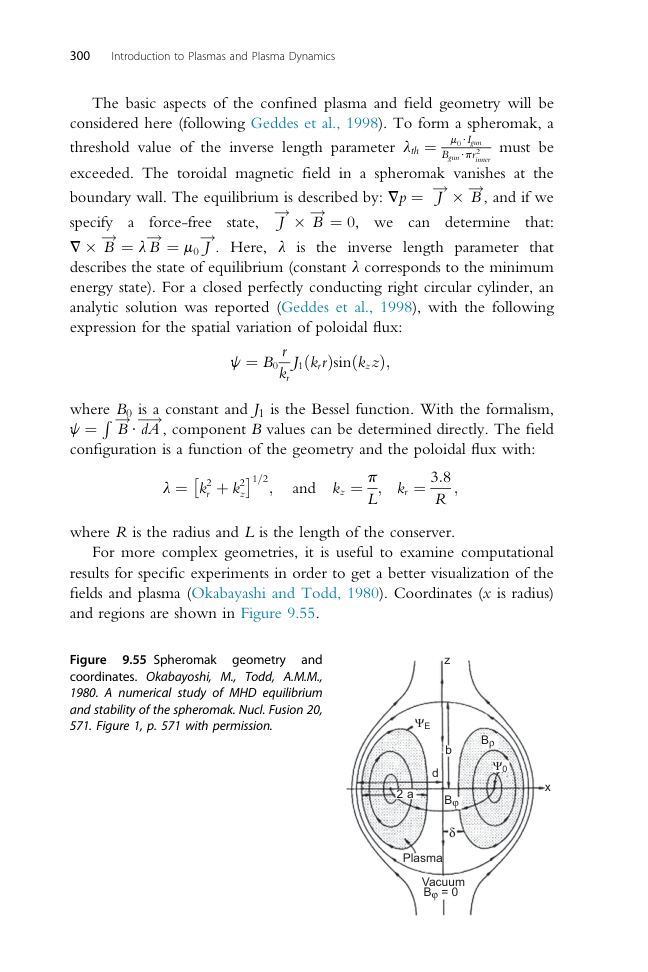

LLM query took 16.11 seconds to process!
(' The image shows a page from a scientific article or paper, with a section '
 'that discusses the conditions necessary for nuclear fusion in a confined '
 'plasma. There are mathematical equations and descriptions related to these '
 'conditions.\n'
 '\n'
 'The text on the page is too small to read in detail, but it appears to be '
 'discussing topics such as "magnetic fields," "plasma confinement," and '
 '"nuclear reactions." The equations include symbols for magnetic field '
 'strength (B), plasma frequency (ωp), and velocity (v). There are also '
 'references to temperature, density, and other parameters that would affect '
 'the fusion process in a confined plasma.\n'
 '\n'
 'The image is focused on the text and the layout of the scientific paper, '
 'which includes the title "ACCOUNT OF THE MANIFOLD," a page number 46, and '
 "the article's abstract summarizing its content. The overall impression is "
 'that this is an academic or techni

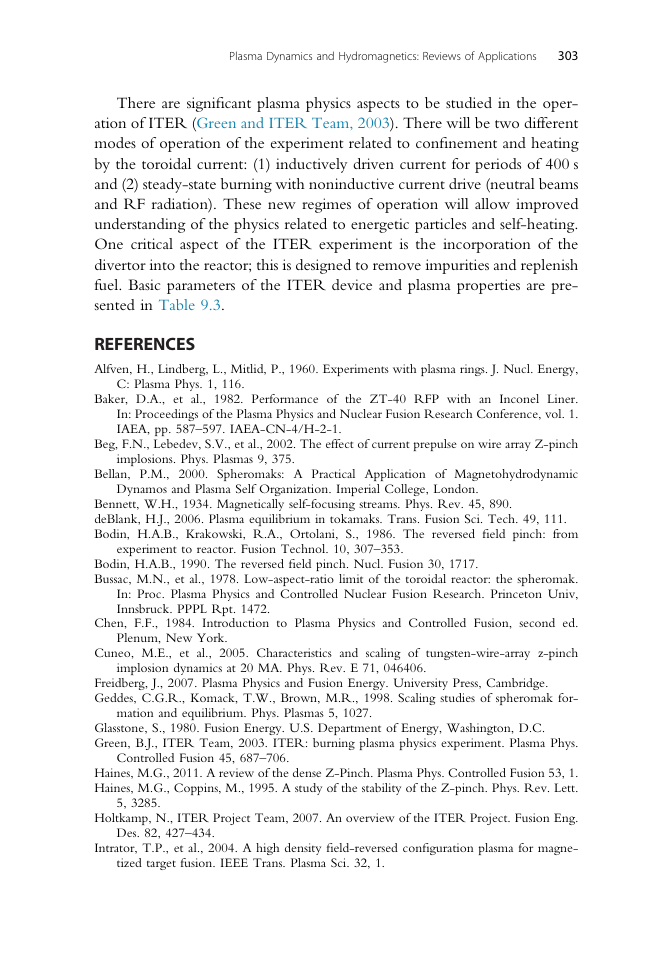

LLM query took 24.58 seconds to process!
(" The image you've provided appears to be a page from an academic or "
 'scientific publication, and it includes a reference section with the title '
 '"Thesis on Nuclear Fusion". However, the text in the body of the document is '
 'not fully visible due to the resolution of the image.\n'
 '\n'
 'To describe the conditions necessary for nuclear fusion in a confined '
 'plasma, I would need to see the full text. But generally, for nuclear fusion '
 'to occur, three main conditions must be met:\n'
 '\n'
 '1. High Temperature: The fuel atoms (usually hydrogen isotopes) must be '
 'heated to incredibly high temperatures, typically in the range of 100-200 '
 'million degrees Celsius, which is necessary to overcome the electrostatic '
 'repulsion between two atomic nuclei.\n'
 '\n'
 '2. High Density: A sufficient number of fuel atoms must be in close '
 'proximity (high density) for successful fusion. This high density can be '
 'achieved by using ma

In [18]:
deep_doc_ask( "Describe the conditions necessary for nuclear fusion in a confined plasma." )